In [1]:
import ee
import geemap
import logging
import multiprocessing
import os
import torch
import pandas as pd
from skimage.measure.entropy import shannon_entropy
import numpy as np
import re
import rasterio
import matplotlib.pyplot as plt
import json
from utils.functions import getResult, getRequests, get_files_info
from sklearn.mixture import GaussianMixture

GEE_PROJECT_ID = "fusion-371234"
ee.Authenticate()
ee.Initialize(project=GEE_PROJECT_ID)

# Dataset

In [ ]:
# ---------------------------------------
# Map and AOI
# ---------------------------------------
Map = geemap.Map(center=[15.851, 78.056], zoom=12)
Map.add_basemap("HYBRID")

aoi = ee.Geometry.Rectangle([
    77.926, 15.723,
    78.186, 15.979
])

# ---------------------------------------
# Dates
# ---------------------------------------
before_date = ('2018-10-26', '2018-10-27')
after_date  = ('2018-11-15', '2018-11-16')

# ---------------------------------------
# Sentinel-2 loader (single best image)
# ---------------------------------------
def get_s2_image(start, end):
    return (
        ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start, end)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .first()
        .clip(aoi)
    )

# ---------------------------------------
# Load images
# ---------------------------------------
img_before = get_s2_image(*before_date)
img_after  = get_s2_image(*after_date)

# ---------------------------------------
# NDVI
# ---------------------------------------
ndvi_before = img_before.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_after  = img_after.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_diff   = ndvi_after.subtract(ndvi_before).rename('NDVI_diff')

# ---------------------------------------
# Visualization parameters
# ---------------------------------------
rgb_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000,
    'gamma': 1.2
}

ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['brown', 'yellow', 'green']
}

diff_vis = {
    'min': -0.4,
    'max': 0.2,
    'palette': ['red', 'white', 'blue']
}

# ---------------------------------------
# Add layers
# ---------------------------------------
Map.addLayer(img_before, rgb_vis, 'Sentinel-2 RGB (Before infestation)')
Map.addLayer(img_after,  rgb_vis, 'Sentinel-2 RGB (After infestation)')

Map.addLayer(ndvi_before, ndvi_vis, 'NDVI (Before infestation)')
Map.addLayer(ndvi_after,  ndvi_vis, 'NDVI (After infestation)')
Map.addLayer(ndvi_diff,   diff_vis, 'NDVI Difference (FAW impact)')

Map.addLayer(aoi, {}, 'Study Area', False)

# ---------------------------------------
# Display
# ---------------------------------------
Map

Map(center=[15.851, 78.056], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [10]:
# Convert to GeoJSON format
geojson_dict = Map.user_roi.getInfo()

# Save to file
with open("india.json", "w") as f:
    json.dump(geojson_dict, f)

print("✅ Region saved as india.json")

✅ Region saved as india.json


## Sentinel-2

In [37]:
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"
selected_bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10  # meters

before_date = ('2018-10-26', '2018-10-27')
after_date  = ('2018-11-15', '2018-11-16')

DATE = after_date  # change to before_date if needed

with open("india.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(DATE[0], DATE[1])
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
)

image = collection.median().clip(region)

os.makedirs("india", exist_ok=True)
geemap.ee_export_image(
    image,
    filename="india/after.tif",
    scale=scale,
    region=region,
    crs=crs,
    file_per_band=False
)

print("✅ Image downloaded exactly as the region geometry.")


Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india/after.tif
✅ Image downloaded exactly as the region geometry.


In [61]:
# --------------------------------------------------
# Parameters
# --------------------------------------------------
S2_SR_COLLECTION_ID = "COPERNICUS/S2_HARMONIZED"

selected_bands = [
    'B1','B2','B3','B4','B5','B6',
    'B7','B8','B8A','B9','B11','B12'
]

CLOUD_FILTER = 100
crs = "EPSG:4326"
scale = 10  # meters

before_date = ('2018-10-26', '2018-10-27')
after_date  = ('2018-11-15', '2018-11-16')

start_date = before_date[0]
end_date   = after_date[1]

# --------------------------------------------------
# Region
# --------------------------------------------------
with open("india.json", "r") as f:
    region_data = json.load(f)

region = ee.Geometry(region_data)

# --------------------------------------------------
# Image collection (FULL TIME SERIES)
# --------------------------------------------------
collection = (
    ee.ImageCollection(S2_SR_COLLECTION_ID)
    .filterDate(start_date, end_date)
    .filterBounds(region)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
    .select(selected_bands)
    .sort('system:time_start')
)

print("Number of images:", collection.size().getInfo())

os.makedirs("india_time_series", exist_ok=True)

image_list = collection.toList(collection.size())
n_images = collection.size().getInfo()

for i in range(n_images):
    img = ee.Image(image_list.get(i))
    
    date = ee.Date(img.get('system:time_start')).format('YYYYMMdd').getInfo()
    
    filename = f"india_time_series/S2_{date}.tif"
    
    geemap.ee_export_image(
        img.clip(region),
        filename=filename,
        scale=scale,
        region=region,
        crs=crs,
        file_per_band=False
    )
    
    print(f"✅ Exported {filename}")

print("🎉 Time-series export completed.")


Number of images: 5
Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india_time_series/S2_20181026.tif
✅ Exported india_time_series/S2_20181026.tif
Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india_time_series/S2_20181031.tif
✅ Exported india_time_series/S2_20181031.tif
Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india_time_series/S2_20181105.tif
✅ Exported india_time_series/S2_20181105.tif
Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india_time_series/S2_20181110.tif
✅ Exported india_time_series/S2_20181110.tif
Generating URL ...
Please wait ...
Data downloaded to /home/fekenzofugi/Documents/rsad-time-series/india_time_series/S2_20181115.tif
✅ Exported india_time_series/S2_20181115.tif
🎉 Time-series export completed.


Total number of files: 5


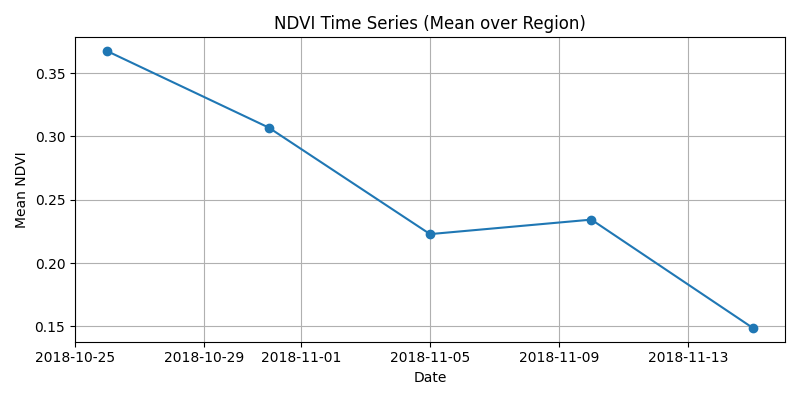

In [69]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

scale = 10000
path = "india_time_series"

# Your working function
n_files, name_files = get_files_info(path)

dates = []
mean_ndvi = []

for file in sorted(name_files):
    # Extract date from filename (adapt if needed)
    date = os.path.basename(file).split("_")[1].replace(".tif", "")
    
    with rasterio.open("india_time_series/" + file) as src:
        # FIX: Use .read() method instead of indexing
        red = src.read(4) / scale
        nir = src.read(8) / scale
        
        nodata = src.nodata
        
        if nodata is not None:
            mask = (red == nodata) | (nir == nodata)
            red = np.where(mask, np.nan, red)
            nir = np.where(mask, np.nan, nir)
        
        # Calculate NDVI with protection against division by zero
        denominator = nir + red
        ndvi = np.where(denominator != 0, (nir - red) / denominator, np.nan)
        
        mean_ndvi.append(np.nanmean(ndvi))
        dates.append(pd.to_datetime(date))

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(dates, mean_ndvi, marker='o')
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.title("NDVI Time Series (Mean over Region)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("ndvi_time_series_india.png", dpi=300)

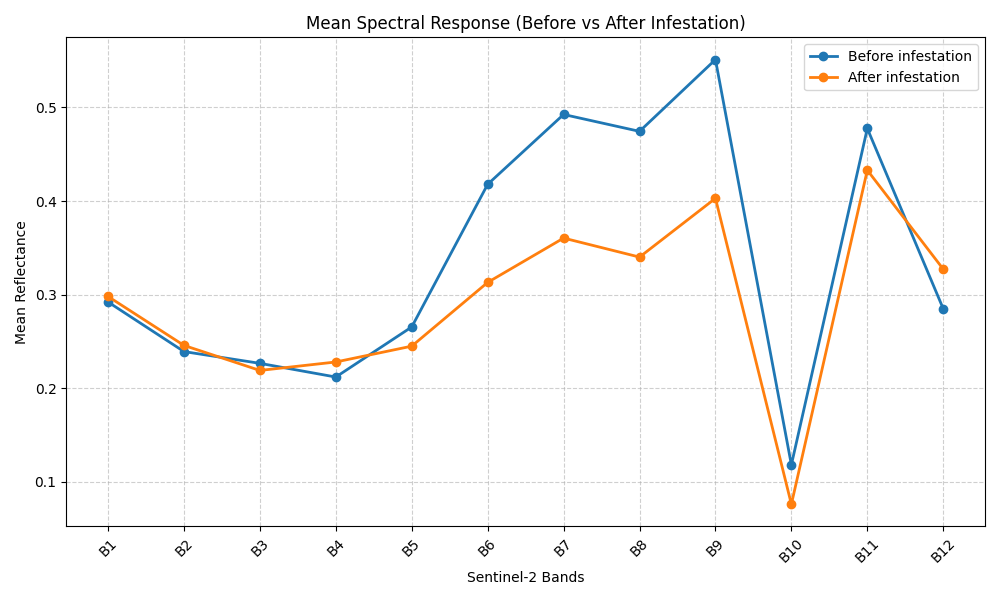

In [59]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

scale = 5000

# ------------------------------------------------------------------
# Paths (change filenames accordingly)
# ------------------------------------------------------------------
before_path = "india/before.tif"
after_path  = "india/after.tif"

# ------------------------------------------------------------------
# Load BEFORE image
# ------------------------------------------------------------------
with rasterio.open(before_path) as src:
    img_before = src.read() / scale
    n_bands = img_before.shape[0]

# ------------------------------------------------------------------
# Load AFTER image
# ------------------------------------------------------------------
with rasterio.open(after_path) as src:
    img_after = src.read() / scale

# ------------------------------------------------------------------
# Compute mean spectral response (ignore NaNs)
# ------------------------------------------------------------------
mean_before = np.nanmean(img_before.reshape(n_bands, -1), axis=1)
mean_after  = np.nanmean(img_after.reshape(n_bands, -1), axis=1)

bands = np.arange(1, n_bands + 1)
band_labels = [f"B{i}" for i in bands]

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))

plt.plot(bands, mean_before, "o-", linewidth=2, label="Before infestation")
plt.plot(bands, mean_after,  "o-", linewidth=2, label="After infestation")

plt.xticks(bands, band_labels, rotation=45)
plt.xlabel("Sentinel-2 Bands")
plt.ylabel("Mean Reflectance")
plt.title("Mean Spectral Response (Before vs After Infestation)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("mean_spectral_response_india.png", dpi=300)


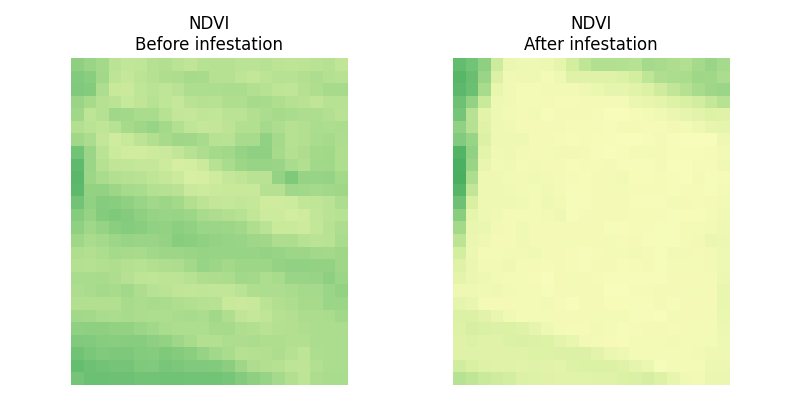

In [56]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

scale = 5000  # reflectance scale used during export

# ------------------------------------------------------------------
# Paths (FULL Sentinel-2 images)
# ------------------------------------------------------------------
before_path = "india/before.tif"
after_path  = "india/after.tif"

# ------------------------------------------------------------------
# NDVI function
# ------------------------------------------------------------------
def compute_ndvi(img, red_idx=3, nir_idx=7):
    red = img[red_idx]
    nir = img[nir_idx]
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

# ------------------------------------------------------------------
# Load BEFORE image
# ------------------------------------------------------------------
with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

# ------------------------------------------------------------------
# Load AFTER image
# ------------------------------------------------------------------
with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

# ------------------------------------------------------------------
# Compute NDVI
# ------------------------------------------------------------------
ndvi_before = compute_ndvi(img_before)
ndvi_after  = compute_ndvi(img_after)

# Mask invalid values
ndvi_before = np.where(np.isfinite(ndvi_before), ndvi_before, np.nan)
ndvi_after  = np.where(np.isfinite(ndvi_after), ndvi_after, np.nan)

# ------------------------------------------------------------------
# Plot (LIKE YOUR FIGURE)
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ndvi_vmin, ndvi_vmax = 0, 1
cmap = "YlGn"

axes[0].imshow(ndvi_before, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[0].set_title("NDVI\nBefore infestation", fontsize=12)

axes[1].imshow(ndvi_after, cmap=cmap, vmin=ndvi_vmin, vmax=ndvi_vmax)
axes[1].set_title("NDVI\nAfter infestation", fontsize=12)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


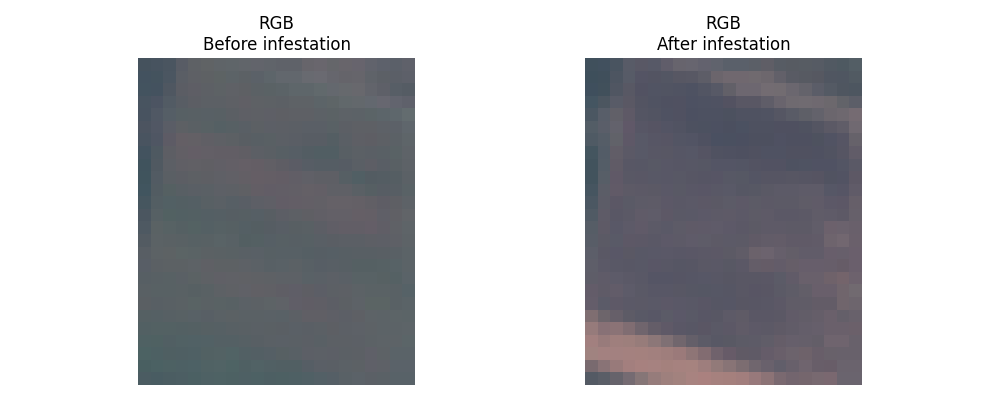

In [50]:
scale = 10000  # reflectance scale

# ---------------------------------------------------
# Paths (FULL Sentinel-2 images)
# ---------------------------------------------------
before_path = "india/before.tif"
after_path  = "india/after.tif"

# ---------------------------------------------------
# Function to build RGB
# ---------------------------------------------------
def make_rgb(img, r=3, g=2, b=1, vmin=0, vmax=0.3):
    rgb = np.stack([img[r], img[g], img[b]], axis=-1)
    rgb = np.clip((rgb - vmin) / (vmax - vmin), 0, 1)
    return rgb

# ---------------------------------------------------
# Load images
# ---------------------------------------------------
with rasterio.open(before_path) as src:
    img_before = src.read().astype(np.float32) / scale

with rasterio.open(after_path) as src:
    img_after = src.read().astype(np.float32) / scale

# ---------------------------------------------------
# Build RGBs
# ---------------------------------------------------
rgb_before = make_rgb(img_before)
rgb_after  = make_rgb(img_after)

# ---------------------------------------------------
# Plot (MATCH STYLE)
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(rgb_before)
axes[0].set_title("RGB\nBefore infestation")

axes[1].imshow(rgb_after)
axes[1].set_title("RGB\nAfter infestation")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()
